# Feature tracing

## Config and preprocessing

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Overwrite once you get good examples
SAMPLE_IDX = 0
TOKEN_IDX = 0

# FEATURE_ID, SAMPLE_IDX, TOKEN_IDX = 15954, 89597, 18  # www1
# FEATURE_ID, SAMPLE_IDX, TOKEN_IDX = 8500, 145713, 24  # www2

FEATURE_ID, SAMPLE_IDX, TOKEN_IDX = 4542, 63202, 73  # it is
# FEATURE_ID, SAMPLE_IDX, TOKEN_IDX = 8, 38, 73 # ')
# FEATURE_ID, SAMPLE_IDX, TOKEN_IDX = 10996, 6948, 3  # 't
BATCH_SIZE = 64
N_BATCHES = 25  # For freqs
HEAD = 0

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

from transformer_lens import utils

from sprint.loading import load_all
from sprint.linearization import analyze_linearized_feature, get_feature_activations
from sprint.attention import get_attn_head_contribs, get_attn_head_contribs_ov
from sprint.sae_tutorial import make_token_df, process_tokens, get_freqs
from sprint.visualization import (
    plot_head_token_contribs,
    plot_head_token_contribs_for_prompt,
    visualize_topk,
    plot_attn_contribs_for_example,
)
from sprint.ablations import dla

In [6]:
model, data, sae = load_all(half_precision=True, verbose=False, fold_ln=True)
# batch = data[:BATCH_SIZE]  # convenience variable for callign make_token_df
BATCH_IDX, IDX_IN_BATCH = SAMPLE_IDX // BATCH_SIZE, SAMPLE_IDX % BATCH_SIZE
batch = data[BATCH_IDX * BATCH_SIZE : (BATCH_IDX + 1) * BATCH_SIZE]

Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
Loading run1 from HuggingFace at 25
{'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 2048,
 'dict_mult': 8,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'lr': 0.0001,
 'model_batch_size': 512,
 'num_tokens': 2000000000,
 'seed': 52,
 'seq_len': 128}


In [82]:
result = analyze_linearized_feature(
    feature_idx=FEATURE_ID,
    sample_idx=SAMPLE_IDX,
    token_idx=TOKEN_IDX,
    model=model,
    data=data,
    encoder=sae,
    head=HEAD,
    # batch_size=BATCH_SIZE,
    # n_batches=100,
)

# TODO: get rid of the TOKEN_IDX argument and automate it instead

## Feature interpretation
We look at:
* A table of specific tokens by feature activations
* A table of specific tokens by activation scores
* A table of generic tokens by unembedded token scores


In [70]:
# freqs = get_freqs(data, model, act_name="mlp_out", layer=0, local_encoder=sae, num_batches=25)
batch_result = get_feature_activations(
    model=model, data=data, encoder=sae, batch_size=BATCH_SIZE, n_batches=N_BATCHES, feature_idx=FEATURE_ID, layer=0
)

print(batch_result["hidden acts"])
print(batch_result["mid acts feature scores"].shape)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 132.54it/s]


NameError: name 'token_idx' is not defined

In [ ]:
# Table of top SAE activations

# token_df = make_token_df(batch, model=model)
token_df = make_token_df(data[: BATCH_SIZE * N_BATCHES], model=model)
token_df["feature"] = utils.to_numpy(feature_act)
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

,str_tokens,unique_token,context,batch,pos,label,feature
56295,·is,·is/103,·or·develop·applications.·It|·is|·attractive,439,103,439/103,2.068359
143386,·is,·is/26,interfaces·class↩ It|·is|·in,1120,26,1120/26,2.062500
142346,·is,·is/10,icroprogrammed.·It|·is|·the,1112,10,1112/10,1.991211
48957,·is,·is/61,·Tote.↩ It|·is|·the,382,61,382/61,1.920898
13469,·is,·is/29,-head·machines.·It|·is|·known,105,29,105/29,1.891602
146161,·is,·is/113,(a).·Thus·it|·is|·the,1141,113,1141/113,1.860352
136958,·is,·is/126,·three·years.↩ It|·is|,1069,126,1069/126,1.846680
100337,·is,·is/113,"·a·new·device,·it|·is|·over",783,113,783/113,1.823242
146954,·is,·is/10,·seats·that·are·free·it|·is|·considered,1148,10,1148/10,1.784180
11526,·is,·is/6,in·is·True·and·it|·is|·the,90,6,90/6,1.727539


In [ ]:
# Table of activation scores

token_df = make_token_df(data[:BATCH_SIZE * N_BATCHES], model=model)
token_df["feature"] = utils.to_numpy(feature_act @ sae.)
token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

SyntaxError: invalid syntax (686647922.py, line 4)

In [ ]:
# Unembed feature

token_df = pd.DataFrame(
    dict(str_tokens=result["token strings"], feature_scores=result["token scores"].detach().cpu().numpy())
)
token_df.style.background_gradient("coolwarm")

,str_tokens,feature_scores
0,present,1.974609
1,measure,1.938477
2,is,1.938477
3,stand,1.916992
4,applies,1.903320
5,gather,1.860352
6,set,1.850586
7,given,1.844727
8,download,1.838867
9,cited,1.836914


Tokens shape: torch.Size([215402, 128]), dtype: torch.int64, device: cuda:0


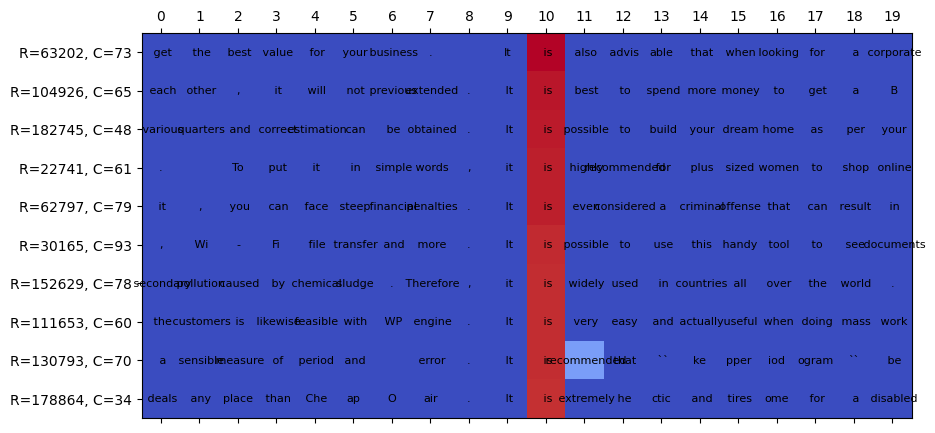

In [73]:
# A more contextualized view of the feature
# This looks at the ACTUAL top K activations in the dataset, not just in a batch

visualize_topk(feature_id=FEATURE_ID, n_examples=10, model=model, data=data, pad=True, clip=10)  # , evenly_spaced=True)
plt.show()

Tokens shape: torch.Size([215402, 128]), dtype: torch.int64, device: cuda:0


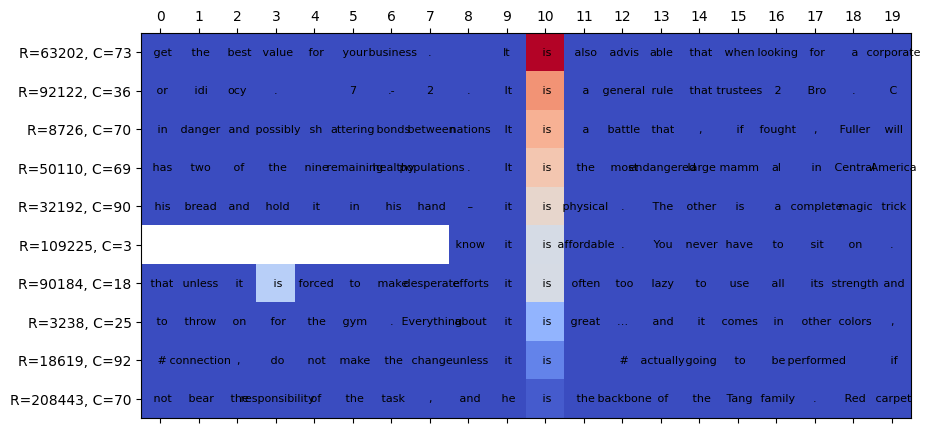

In [74]:
# Same but evenly spaced
visualize_topk(feature_id=FEATURE_ID, n_examples=10, model=model, data=data, pad=True, clip=10, evenly_spaced=True)
plt.show()

I skipped the exploration of linearization points, because you can do this by just changing the `sample_idx` and `token_idx` parameters in `anlyze_linearized_feature()`

## Attention

### Head contributions

In [ ]:
# attn_contribs = get_attn_head_contribs(
#     model=model, data=data, layer=0, range_normal=result["mid"], batch_size=BATCH_SIZE
# )

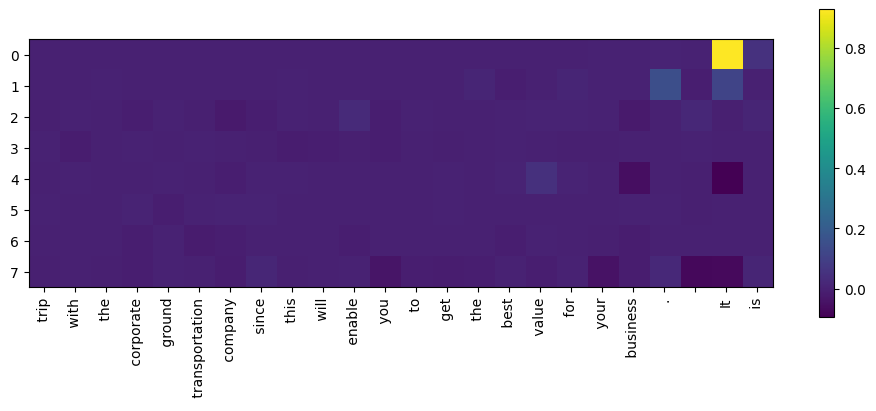

In [75]:
# plot_head_token_contribs(model=model, contribs=attn_contribs, tokens=data[SAMPLE_IDX], dst=TOKEN_IDX)
# plt.show()

plot_attn_contribs_for_example(
    model=model,
    data=data,
    example_idx=SAMPLE_IDX,
    token_idx=TOKEN_IDX,
    # example_idx=90184,
    # token_idx=18,
    feature_mid=result["mid"],
    start_token_idx=50,
    ov_only=False,
    layer=0,
    batch_size=BATCH_SIZE,
)
plt.colorbar()

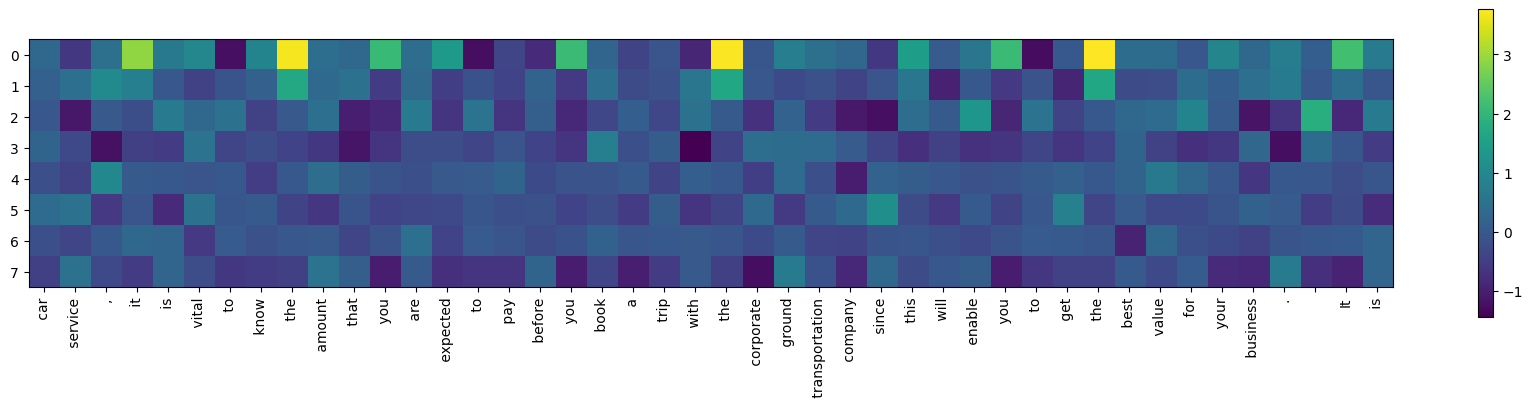

In [89]:
# OV only version

plot_attn_contribs_for_example(
    model=model,
    data=data,
    example_idx=SAMPLE_IDX,
    token_idx=TOKEN_IDX,
    feature_mid=result["mid"],
    start_token_idx=30,
    ov_only=True,
    layer=0,
    batch_size=BATCH_SIZE,
)
plt.colorbar()

Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cuda
Changing model dtype to torch.float16
Model device: cuda:0


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (14).

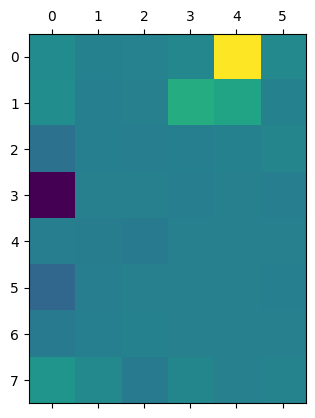

In [78]:
# prompt = "\n           'sms_id_string':   ('"
prompt = "Full stop. It is in your best interest to comply with this request"
plot_head_token_contribs_for_prompt(
    model=model,
    prompt=prompt,
    range_normal=result["mid"],
    # dst=-1,
    dst=5,
    prepend_bos=True,
)
plt.show()

# TODO: figure out whether there's an off-by-one error in the attention visualization
# TODO: fix the activating examples visualization

### OV circuit

In [83]:
# Scores when OV circuit is accounted for before unembedding

token_df = pd.DataFrame(
    dict(
        str_tokens=process_tokens(result["OV token strings"], model=model),
        feature_scores=result["OV token scores"].detach().cpu().numpy(),
    )
)
token_df.style.background_gradient("coolwarm")

,str_tokens,feature_scores
0,·the,0.738770
1,·antit,0.672852
2,·unequiv,0.669922
3,·pert,0.659180
4,·comes,0.651855
5,the,0.633301
6,·Suff,0.622559
7,·come,0.615723
8,·it,0.540039
9,The,0.539551


In [84]:
# Same as above, but ln + OV

token_df = pd.DataFrame(
    dict(
        str_tokens=process_tokens(result["ln+OV token strings"], model=model),
        feature_scores=result["ln+OV token scores"].detach().cpu().numpy(),
    )
)
token_df.style.background_gradient("coolwarm")

# TODO: look into what's broken about this
# TODO: what's going on with the positional embeddings?

,str_tokens,feature_scores
0,�,0.475830
1,�,0.464600
2,8,0.461182
3,re,0.459229
4,�,0.453369
5,�,0.448730
6,he,0.439697
7,�,0.437500
8,,0.434326
9,==,0.426270


### QK circuit

In [85]:
token_df = pd.DataFrame(
    dict(
        str_tokens=process_tokens(result["QK token strings"], model=model),
        feature_scores=result["QK token scores"].detach().cpu().numpy(),
    )
)
token_df.style.background_gradient("coolwarm")

,str_tokens,feature_scores
0,·intercepted,0.489014
1,redirect,0.487061
2,·materially,0.467285
3,·curt,0.449707
4,·birthday,0.444336
5,·indirectly,0.430908
6,·discretion,0.430908
7,······,0.426514
8,·veil,0.423828
9,··,0.421875


In [159]:
from re import S
from sprint.attention import do_single_token_qk

do_single_token_qk(
    dst_token_str=" is",
    dst_pos=41,
    # src_token_str=" It",
    # src_pos=38,
    # src_pos=40,
    # src_token_str=".",
    # src_pos=38,
    src_token_str = " placebo",
    src_pos = 38,
    head=0,
    model=model,
)

31.3125

In [197]:
# More intense QK investigation

tokens = [" It", " it", "it", ".", ",", "\n", " intercepted", "redirect", " materially", " the", " antit", " unequiv"]
posns = [-5, -4, -3, -2, -1]

results_df = pd.DataFrame(index=tokens, columns=posns, dtype=float)

for token in tokens:
    for pos in posns:
        score = do_single_token_qk(
            dst_token_str=" is",
            dst_pos=41,
            src_token_str=token,
            src_pos=41 + pos,
            head=0,
            model=model,
        )
        results_df.loc[token, pos] = score

# results_df.style.background_gradient("coolwarm")
# results_df
        
results_df.style.background_gradient("coolwarm", axis=0)

,-5,-4,-3,-2,-1
It,33.281250,40.125000,47.281250,56.750000,66.187500
it,29.343750,36.750000,44.437500,54.656250,64.750000
it,28.921875,35.531250,42.468750,51.625000,60.687500
.,25.156250,32.062500,39.250000,48.781250,58.281250
",",31.515625,38.343750,45.531250,54.968750,64.312500
,23.593750,30.250000,37.187500,46.406250,55.531250
intercepted,38.625000,43.968750,49.500000,56.843750,64.125000
redirect,20.468750,27.156250,34.093750,43.281250,52.437500
materially,26.031250,31.953125,38.187500,46.375000,54.437500
the,23.859375,30.687500,37.812500,47.218750,56.593750


In [217]:
# What's the ranking of " intercepted" in OV vectors?
import torch

from sprint.linearization import get_feature_mid

def get_ov_unembed(model, head, feature_mid, ln_token=None, pos_idx=0, layer=0, unembed=True):
  if ln_token is None:
    x = model.OV[layer,head] @ feature_mid
  else:
    x = get_tangent_plane_at_point(
      model.W_E[model.to_single_token(ln_token)] + model.W_pos[pos_idx],
      lambda x: ln_ov(x, model, layer, head), feature_mid)
  if unembed: x = model.W_E @ x
  return x

sorted_vals, sorted_indices = torch.sort(get_ov_unembed(model, 0, result["mid"]), descending=True)
torch.arange(len(sorted_vals))[sorted_indices.to('cpu') == model.to_single_token(" intercepted")]

tensor([68])

In [218]:
for token in [" It", " it", " intercepted", "redirect"]:
    print(token, torch.arange(len(sorted_vals))[sorted_indices.to('cpu') == model.to_single_token(token)])

 It tensor([68])
 it tensor([8])
 intercepted tensor([45759])
redirect tensor([12481])


## Direct feature attribution

In [12]:
dla(model, data[SAMPLE_IDX], layer=1, range_normal=sae.W_enc[:, FEATURE_ID] @ model.blocks[0].mlp.W_out, dst_token=TOKEN_IDX)

torch.Size([1, 128, 512])


[(0.10247802734375, ('resid_pre', 0)),
 (2.208984375, ('attn_out', 0)),
 (15.078125, ('mlp_out', 0))]